<a href="https://colab.research.google.com/github/AKMADOU/Convolutional-neural-Network/blob/main/ADOU_Kouam%C3%A9_Mathurin_convnet_tutorial2_filled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The tutorials use PyTorch. You will need to load the following dependencies.

In [ ]:
import random

import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import skimage.transform
import torch
import torch.nn as nn
import torch.utils.data
import torchvision
from IPython import display
from torchvision import datasets, transforms

# Tutorial 2a: Convolutional Neural Network (CNN)

The code below may be helpful in visualizing PyTorch tensors as images.

In [ ]:
%matplotlib inline


def show(img):
    """Show PyTorch tensor img as an image in matplotlib."""
    npimg = img.cpu().detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation="nearest")
    plt.grid(False)
    plt.gca().axis("off")


def display_thumb(img):
    display.display(transforms.Resize(128)(img))

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Load MNIST and define train/test functions as before. Please make sure you read the code carefully and understand what it is doing.

In [ ]:
# Load the training and test dataset.
mnist_train = datasets.MNIST(
    "/tmp/mnist", train=True, download=True, transform=transforms.ToTensor()
)
mnist_test = datasets.MNIST(
    "/tmp/mnist", train=False, download=True, transform=transforms.ToTensor()
)

# Size of the batches the data loader will produce.
batch_size = 64

# This creates the dataloaders.
train_loader = torch.utils.data.DataLoader(
    mnist_train, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    mnist_test, batch_size=batch_size, shuffle=False
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /tmp/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /tmp/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /tmp/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /tmp/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw



In [ ]:
def train(model, criterion, data_loader, optimizer, num_epochs):
    """Simple training loop for a PyTorch model."""

    # Make sure model is in training mode.
    model.train()

    # Move model to the device (CPU or GPU).
    model.to(device)

    # Exponential moving average of the loss.
    ema_loss = None

    # Loop over epochs.
    for epoch in range(num_epochs):

        # Loop over data.
        for batch_idx, (data, target) in enumerate(data_loader):

            # Forward pass.
            output = model(data.to(device))
            loss = criterion(output.to(device), target.to(device))

            # Backward pass.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # NOTE: It is important to call .item() on the loss before summing.
            if ema_loss is None:
                ema_loss = loss.item()
            else:
                ema_loss += (loss.item() - ema_loss) * 0.01

        # Print out progress the end of epoch.
        print(
            "Train Epoch: {} \tLoss: {:.6f}".format(epoch, ema_loss),
        )


def test(model, data_loader):
    """Measures the accuracy of a model on a data set."""
    # Make sure the model is in evaluation mode.
    model.eval()
    correct = 0

    # We do not need to maintain intermediate activations while testing.
    with torch.no_grad():

        # Loop over test data.
        for data, target in data_loader:

            # Forward pass.
            output = model(data.to(device))

            # Get the label corresponding to the highest predicted probability.
            pred = output.argmax(dim=1, keepdim=True)

            # Count number of correct predictions.
            correct += pred.cpu().eq(target.view_as(pred)).sum().item()

    # Print test accuracy.
    percent = 100.0 * correct / len(data_loader.dataset)
    print(f"Accuracy: {correct} / {len(data_loader.dataset)} ({percent:.0f}%)")
    return percent

. define a function

convolution operation

inputs: X,K


.Return O of the convolution operation

.padding, stride=1

In the last tutorial, you implemented a naive convolution. In this section you will implement your own version of forward pass of nn.Conv2d without using any of PyTorch's (or numpy's) pre-defined convolutional functions.

In [ ]:
def convoluton_operation(X,K,padding,stride=1):
  H,W=X.shape
  h,w=K.shape

  H_o=H-h+1
  W_o=W-w+1
  O=torch.zeros(H_o,W_o)
  output=1+(H+2*padding-W)//stride
  return output
  

In [ ]:
def conv_forward_naive(x, w, b, conv_param):
    """
    A naive Python implementation of a convolutional layer.
    The input consists of N data points, each with C channels, height H and
    width W. We convolve each input with F different filters, where each filter
    spans all C channels and has height HH and width WW.
    Input:
    - x: Input data of shape (N, C, H, W)
    - w: Filter weights of shape (F, C, HH, WW)
    - b: Biases, of shape (F,)
    - conv_param: A dictionary with the following keys:
      - 'stride': The number of pixels between adjacent receptive fields in the
        horizontal and vertical directions.
      - 'pad': The number of pixels that will be used to zero-pad the input.

    During padding, 'pad' zeros should be placed symmetrically (i.e., equally on both sides)
    along the height and width axes of the input. Be careful not to modfiy the original
    input x directly.
    Returns an array.
    - out: Output data, of shape (N, F, H', W') where H' and W' are given by
      H' = 1 + (H + 2 * pad - HH) / stride
      W' = 1 + (W + 2 * pad - WW) / stride
    """
    out = None

    N, C, H, W = x.shape
    num_filters, _, filter_height, filter_width = w.shape
    stride, pad = conv_param["stride"], conv_param["pad"]

    # Check dimensions.
    assert (W + 2 * pad - filter_width) % stride == 0, "width does not work"
    assert (H + 2 * pad - filter_height) % stride == 0, "height does not work"

    ###########################################################################
    # TODO: Implement the forward pass of a convolutional layer without using #
    #       nn.Conv2D or other implementations of convolutions. Instead, use  #
    #       standard for- and while-loops to iterate over the tensors.        #
    #                                                                         #
    # Hint: you can use the function torch.nn.functional.pad for padding.     #
    ###########################################################################
    H_=1+(H-filter_height+2*pad)//stride
    W_=1+(W-filter_width+2*pad)//stride
    output = torch.empty(N,num_filters,H_,W_)
    x= torch.nn.functional.pad(x,(pad,pad,pad,pad))
    for t in range(N):
      s = x[t,:, :,:]
      for l in range(num_filters):
        a = 0
        for i in range(H_):
          h =0
          for j in range(W_):

            output[t,l,i,j]= torch.mul(w[l],s[:,a:filter_height+a , h: filter_width+ h ]).sum()+b[l]
            h+= stride
          a+= stride
    return output


You can test your implementation by running the following testing code:

In [ ]:
# Make convolution module.
w_shape = (3, 3, 4, 4)
w = torch.linspace(-0.2, 0.3, steps=torch.prod(torch.tensor(w_shape))).reshape(w_shape)
b = torch.linspace(-0.1, 0.2, steps=3)

# Compute output of module and compare against reference values.
x_shape = (2, 3, 4, 4)
x = torch.linspace(-0.1, 0.5, steps=torch.prod(torch.tensor(x_shape))).reshape(x_shape)
out = conv_forward_naive(x, w, b, {"stride": 2, "pad": 1})

correct_out = torch.tensor(
    [
        [
            [[-0.08759809, -0.10987781], [-0.18387192, -0.2109216]],
            [[0.21027089, 0.21661097], [0.22847626, 0.23004637]],
            [[0.50813986, 0.54309974], [0.64082444, 0.67101435]],
        ],
        [
            [[-0.98053589, -1.03143541], [-1.19128892, -1.24695841]],
            [[0.69108355, 0.66880383], [0.59480972, 0.56776003]],
            [[2.36270298, 2.36904306], [2.38090835, 2.38247847]],
        ],
    ]
)

# Compare your output to ours; difference should be around e-8
print("Testing conv_forward_naive")
rel_error = ((out - correct_out) / (out + correct_out + 1e-6)).mean()
print("difference: ", rel_error)
if abs(rel_error) < 1e-6:
    print("Nice work! Your implementation of a convolution layer works correctly.")
else:
    print(
        "Something is wrong. The output was expected to be {} but it was {}".format(
            correct_out, out
        )
    )

Testing conv_forward_naive
difference:  tensor(2.8497e-08)
Nice work! Your implementation of a convolution layer works correctly.



We will now replace the logistic regressor from the last tutorial by a small convolutional network with two convolutional layers and a linear layer, and ReLU activations in between the layers. Implement the model and use the same functions as before to train and test the convolutional network.

In [ ]:
# X=(28,28,3); K=(5,5)
# nn.Conv2D(3,8,5)==convolution layer
# what is the number of parameters of the first layer (without bias)?
# 5*5*3*8
# I decide to do a pooling transformation: the number of parameters will not change
# nn.Sequential(nn.con)

In [ ]:
class ConvolutionalNetwork(nn.Module):
    """Simple convolutional network."""

    def __init__(self, image_side_size, num_classes, in_channels=1):
        super(ConvolutionalNetwork, self).__init__()

        # Fill these in:
        ##########################################################################
        # TODO: Implement a convulutional and a linear part.                     #
        # Hint: see forward() to understand how they should work together.       #
        ##########################################################################
        self.conv_network = nn.Sequential(
            nn.Conv2d(in_channels,out_channels=6,kernel_size=3),
            
            nn.ReLU(),
            nn.Conv2d(in_channels=6,out_channels=8,kernel_size=7),
            nn.ReLU())      
        self.linear = nn.Linear(8*20*20, num_classes)

    def forward(self, x):
        x = self.conv_network(x)
        x = self.linear(x.view(x.size(0), -1))
        return x


# Create and train convolutional network.
# The accuracy should be around 96%.
conv_model = ConvolutionalNetwork(28, 10)
###########################################################################
# TODO: Create criterion and optimize here.                               #
###########################################################################
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(conv_model.parameters(),lr=0.001)

train(conv_model, criterion, train_loader, optimizer, num_epochs=5)
test(conv_model, test_loader)

Train Epoch: 0 	Loss: 0.090654
Train Epoch: 1 	Loss: 0.063515
Train Epoch: 2 	Loss: 0.055778
Train Epoch: 3 	Loss: 0.047112
Train Epoch: 4 	Loss: 0.038331
Accuracy: 9860 / 10000 (99%)


98.6

Inspect the filters in the first layer of the trained convolutional network. What do they look like? Why?

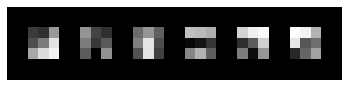

In [ ]:
first_conv = list(conv_model.conv_network.children())[0]
show(
    torchvision.utils.make_grid(
        first_conv.weight,
        normalize=True,
        nrow=8,
    )
)